**AnyModal/LaTeX-OCR-Llama-3.2-1B**

In [1]:
import llm
import anymodal
import torch
import vision
import numpy as np
import os
from PIL import Image
from huggingface_hub import snapshot_download
from IPython.display import display, Math
from tqdm.auto import tqdm

# Load language model and tokenizer
llm_tokenizer, llm_model = llm.get_llm(
    "meta-llama/Llama-3.2-1B", 
    access_token="your_access_token",
    quantized = False,
    use_peft = False
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

llm_hidden_size = llm.get_hidden_size(llm_tokenizer, llm_model)
llm_model.to(device)

# Load vision model components
image_processor, vision_model, vision_hidden_size = vision.get_image_encoder('google/siglip-so400m-patch14-384', use_peft=False)


# Initialize vision tokenizer and encoder
vision_encoder = vision.VisionEncoder(vision_model)
vision_tokenizer = vision.Projector(vision_hidden_size, llm_hidden_size, num_hidden=1)


# Initialize MultiModalModel
multimodal_model = anymodal.MultiModalModel(
    input_processor=None,
    input_encoder=vision_encoder,
    input_tokenizer=vision_tokenizer,
    language_tokenizer=llm_tokenizer,
    language_model=llm_model,
    prompt_text="The latex expression of the equation in the image is:")

if not os.path.exists("latex_ocr"):
    os.makedirs("latex_ocr")

snapshot_download("AnyModal/latex-ocr-Llama-3.2-1B", local_dir="latex_ocr")

multimodal_model._load_model('latex_ocr')

multimodal_model.eval()

/home/jmeadows17/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 7155.48it/s]
/home/jmeadows17/AI/LaTeX OCR/anymodal.py:249: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `tor

MultiModalModel(
  (input_encoder): VisionEncoder(
    (model): SiglipVisionModel(
      (vision_model): SiglipVisionTransformer(
        (embeddings): SiglipVisionEmbeddings(
          (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
          (position_embedding): Embedding(729, 1152)
        )
        (encoder): SiglipEncoder(
          (layers): ModuleList(
            (0-26): 27 x SiglipEncoderLayer(
              (self_attn): SiglipSdpaAttention(
                (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
                (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
              )
              (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
              (mlp): SiglipMLP(
                (activation_fn): PytorchGELUT

In [2]:
def prediction(i,model=multimodal_model,image_processor=image_processor,max_new_tokens=120):
    image_path = f"Equations/{i}.PNG"
    image = Image.open(image_path).convert("RGB")
    processed_image = image_processor(images = image, return_tensors="pt")
    processed_image = {key: val.squeeze(0) for key, val in processed_image.items()}
    pred = model.generate(processed_image, max_new_tokens=max_new_tokens)

    with open(f"Equations/{i}.txt", "r", encoding="utf-8") as file:
        reference = file.read()

    display(image)

    return {
        "image":image,
        "1B-prediction":pred,
        "reference":reference
    }

  0%|          | 0/11 [00:00<?, ?it/s]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


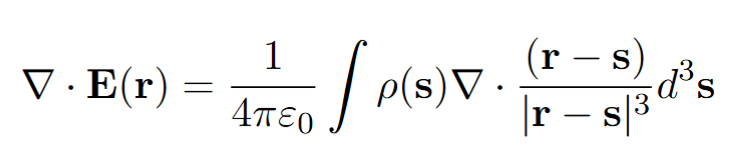

  9%|▉         | 1/11 [00:02<00:29,  2.96s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


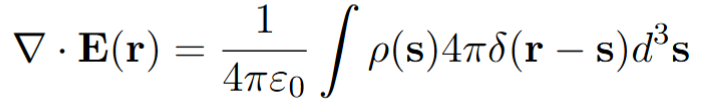

 18%|█▊        | 2/11 [00:05<00:25,  2.84s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


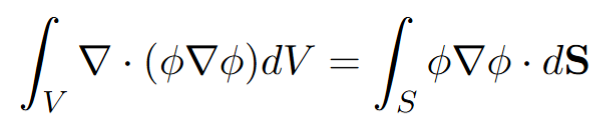

 27%|██▋       | 3/11 [00:07<00:20,  2.57s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


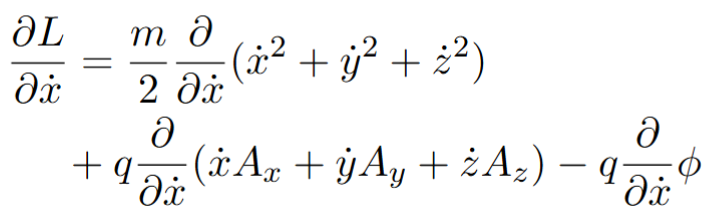

 36%|███▋      | 4/11 [00:10<00:18,  2.64s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


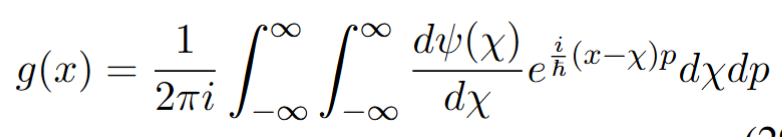

 45%|████▌     | 5/11 [00:13<00:16,  2.67s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


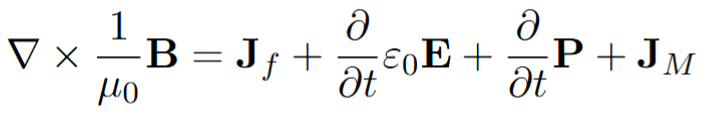

 55%|█████▍    | 6/11 [00:16<00:13,  2.69s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


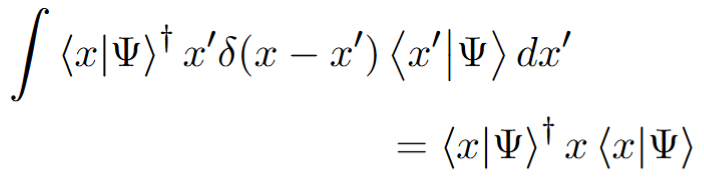

 64%|██████▎   | 7/11 [00:18<00:10,  2.70s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


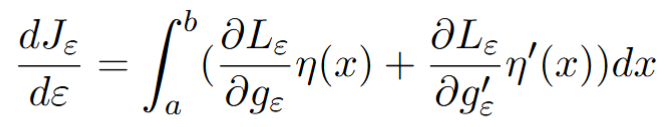

 73%|███████▎  | 8/11 [00:21<00:08,  2.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


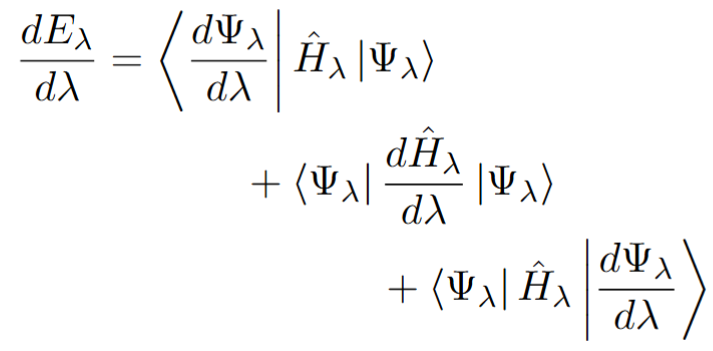

 82%|████████▏ | 9/11 [00:24<00:05,  2.71s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


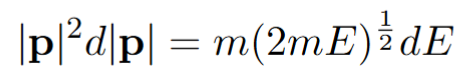

 91%|█████████ | 10/11 [00:27<00:02,  2.72s/it]Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


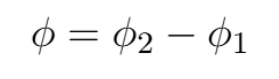

100%|██████████| 11/11 [00:28<00:00,  2.56s/it]


In [3]:
data = []
for i in tqdm(range(1, 12)):
    data.append(prediction(i))

In [4]:
import pandas as pd
llm_model, vision_model, multimodal_model = None, None, None
df = pd.DataFrame(data)
df.to_csv("llama-1B-predictions_few_shot.csv")
display(df)

,image,1B-prediction,reference
0,<PIL.Image.Image image mode=RGB size=733x157 a...,\nabla \cdot E \cdot E \left( r \right) = \fra...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1}...
1,<PIL.Image.Image image mode=RGB size=701x105 a...,\nabla \cdot \cdot E \mathrm { r } = \frac { 1...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1}...
2,<PIL.Image.Image image mode=RGB size=602x121 a...,\int \left. \nabla \times \left. \left. \nabla...,\int_V \nabla \cdot (\phi\nabla\phi) dV = \int...
3,<PIL.Image.Image image mode=RGB size=722x221 a...,\partial _ { x } L = \frac { \partial L } { \p...,\frac{\partial L}{\partial \dot{x}} = \frac{m}...
4,<PIL.Image.Image image mode=RGB size=782x137 a...,g ( x ) \left( x ^ { \prime } ; \alpha \right)...,g(x) = \frac{1}{2\pi i}\int_{-\infty}^{\infty}...
5,<PIL.Image.Image image mode=RGB size=713x116 a...,\nabla \times \frac { 1 } { V } \times \frac {...,\nabla \times \frac{1}{\mu_0}\mathbf{B} = \mat...
6,<PIL.Image.Image image mode=RGB size=704x186 a...,\int \left\langle x \mid \Psi \right\rangle \d...,\int \braket{x}{\Psi}^{\dagger}x'\delta(x-x') ...
7,<PIL.Image.Image image mode=RGB size=672x127 a...,\frac { d L } { d \epsilon } = \int _ { a } ^ ...,\frac{dJ_{\varepsilon}}{d\varepsilon} = \int_{...
8,<PIL.Image.Image image mode=RGB size=713x351 a...,\begin{array} { l l l } { \langle d E \rangle ...,\frac{d E_\lambda}{d\lambda} = \bra{\frac{d \P...
9,<PIL.Image.Image image mode=RGB size=470x72 at...,\vert p \vert ^ { 2 } / { \cal D } ^ { 2 } \ve...,|\mathbf{p}|^2 d|\mathbf{p}| = m (2mE)^{\frac{...


**LLaMa-3.2-11B-vision**

In [25]:
import torch
import pandas as pd
from tqdm.auto import tqdm
from PIL import Image
from transformers import MllamaForConditionalGeneration, AutoProcessor

model_id = "meta-llama/Llama-3.2-11B-Vision"

model = MllamaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)
processor = AutoProcessor.from_pretrained(model_id)

Loading checkpoint shards: 100%|██████████| 5/5 [00:07<00:00,  1.55s/it]


In [2]:
def prediction(i,model=model,processor=processor,max_new_tokens=120):
    image_path = f"Equations/{i}.PNG"
    image = Image.open(image_path).convert("RGB")
    prompt = "<|image|><|begin_of_text|>The latex expression of the equation in the image is:"
    inputs = processor(image, prompt, return_tensors="pt").to(model.device)

    with open(f"Equations/{i}.txt", "r", encoding="utf-8") as file:
        reference = file.read()

    output = model.generate(**inputs, max_new_tokens=max_new_tokens)
    pred = processor.decode(output[0])

    return {
        "image":image,
        "11B-prediction":pred,
        "reference":reference
    }

In [3]:
data_2 = []
for i in tqdm(range(1, 12)):
    data_2.append(prediction(i))

df = pd.DataFrame(data_2)
df.to_csv("llama-11B-predictions.csv")
df

100%|██████████| 11/11 [57:27<00:00, 313.40s/it] 


**Evaluate Initial Models**

In [1]:
import pandas as pd
from evaluate import load
df = pd.read_csv("llama-1B-predictions.csv",index_col=0)
df_2 = pd.read_csv("llama-11B-predictions.csv", index_col=0)
df["11B-prediction"] = [i.replace("<|begin_of_text|><|image|><|begin_of_text|>The latex expression of the equation in the image is:","").split("<OCR")[0].replace("\\n","") for i in list(df_2["11B-prediction"])]
df.head()

/home/jmeadows17/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,image,1B-prediction,reference,11B-prediction
0,<PIL.Image.Image image mode=RGB size=733x157 a...,\nabla \cdot E \cdot E ( r ) = { \frac { 1 } {...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1}...,
1,<PIL.Image.Image image mode=RGB size=701x105 a...,\nabla \cdot \cdot E r \left( { \frac { 1 } { ...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1}...,\mathbf{E}(\mathbf{r})=\frac{1}{4\pi\epsilon_...
2,<PIL.Image.Image image mode=RGB size=602x121 a...,\int \! \int \! \int \! \int \! \! \int \left(...,\int_V \nabla \cdot (\phi\nabla\phi) dV = \int...,\int_{V} abla \cdot(\phi abla \phi) dV = \int...
3,<PIL.Image.Image image mode=RGB size=722x221 a...,\frac { \partial L } { \partial x } = \frac { ...,\frac{\partial L}{\partial \dot{x}} = \frac{m}...,\(\frac{\partial L}{\partial \dot{x}}=\frac{m...
4,<PIL.Image.Image image mode=RGB size=782x137 a...,g ( x ) = \frac { 1 } { 2 \pi } \int _ { - \in...,g(x) = \frac{1}{2\pi i}\int_{-\infty}^{\infty}...,g(x) = 1/(2*pi*i) * integral from -infinity t...


In [8]:
from tqdm.auto import tqdm
def score(metric_name, pred, ref):
    metric = load(metric_name)
    try:
        score = metric.compute(predictions=[pred],references=[ref])
    except:
        return 0.0
    key = "rouge2" if metric_name == "rouge" else "bleu"
    return score[key]

model_names = ["1B","11B"]
metric_names = ["rouge","bleu"]
for m in tqdm(model_names):
    for n in metric_names:
        df[f"{m}_{n}"] = [score(n, df[f"{m}-prediction"].iloc[i], df["reference"].iloc[i]) for i in range(len(df))]

100%|██████████| 2/2 [01:05<00:00, 32.86s/it]


In [11]:
results = [
    {
        "model":"LLaMa-3.2-1B-OCR-LaTeX",
        "rouge":round(sum(list(df["1B_rouge"]))/len(df),2),
        "bleu":round(sum(list(df["1B_bleu"]))/len(df),2)
    },
    {
        "model":"LLaMa-3.2-11B",
        "rouge":round(sum(list(df["11B_rouge"]))/len(df),2),
        "bleu":round(sum(list(df["11B_bleu"]))/len(df),2)
    }
]

results = pd.DataFrame(results)
results

,model,rouge,bleu
0,LLaMa-3.2-1B-OCR-LaTeX,0.2,0.23
1,LLaMa-3.2-11B,0.5,0.38


**Design few-shot prompt and retry 11B model**

In [14]:
df_fs = pd.read_csv("llama-1B-predictions_few_shot.csv",index_col=0)

# manually selected for now, but could be easily automated
# we are also sourcing the few-shot examples from the test set, which obviously would not be done in practice (leakage)
examples = [
    {
        "incorrect":df_fs["1B-prediction"].iloc[6],
        "correct":df_fs["reference"].iloc[6]
    },
    {
        "incorrect":df_fs["1B-prediction"].iloc[10],
        "correct":df_fs["reference"].iloc[10]
    },
    {
        "incorrect":df_fs["1B-prediction"].iloc[2],
        "correct":df_fs["reference"].iloc[2]
    }
]

In [ ]:
def few_shot_prompt(num_examples, examples=examples):
    prompt = "<|image|><|begin_of_text|>Determine the Correct LaTeX expression of the equation in the image. Below are examples of Incorrect and Correct LaTeX equations: \n\n"

    for i in range(num_examples):
        prompt += "Incorrect: %s \n\n"%(examples[i]["incorrect"])
        prompt += "Correct: %s \n\n"%(examples[i]["correct"])

    prompt += "Give the Correct LaTeX from the image. Correct:"
    return prompt

In [31]:
def prediction(i,model=model,processor=processor,max_new_tokens=120,num_examples=1):
    image_path = f"Equations/{i}.PNG"
    image = Image.open(image_path).convert("RGB")
    prompt = few_shot_prompt(num_examples)
    inputs = processor(image, prompt, return_tensors="pt").to(model.device)

    with open(f"Equations/{i}.txt", "r", encoding="utf-8") as file:
        reference = file.read()

    output = model.generate(**inputs, max_new_tokens=max_new_tokens)
    pred = processor.decode(output[0])

    return {
        "image":image,
        "11B-prediction":pred,
        "reference":reference
    }

In [32]:
data = []
for i in tqdm(range(1, 12)):
    data.append(prediction(i))

df = pd.DataFrame(data)
df.to_csv("FS-llama-11B-predictions_1.csv")
df

100%|██████████| 11/11 [51:29<00:00, 280.91s/it]


,image,11B-prediction,reference
0,<PIL.Image.Image image mode=RGB size=733x157 a...,<|begin_of_text|><|image|><|begin_of_text|>Det...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1}...
1,<PIL.Image.Image image mode=RGB size=701x105 a...,<|begin_of_text|><|image|><|begin_of_text|>Det...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1}...
2,<PIL.Image.Image image mode=RGB size=602x121 a...,<|begin_of_text|><|image|><|begin_of_text|>Det...,\int_V \nabla \cdot (\phi\nabla\phi) dV = \int...
3,<PIL.Image.Image image mode=RGB size=722x221 a...,<|begin_of_text|><|image|><|begin_of_text|>Det...,\frac{\partial L}{\partial \dot{x}} = \frac{m}...
4,<PIL.Image.Image image mode=RGB size=782x137 a...,<|begin_of_text|><|image|><|begin_of_text|>Det...,g(x) = \frac{1}{2\pi i}\int_{-\infty}^{\infty}...
5,<PIL.Image.Image image mode=RGB size=713x116 a...,<|begin_of_text|><|image|><|begin_of_text|>Det...,\nabla \times \frac{1}{\mu_0}\mathbf{B} = \mat...
6,<PIL.Image.Image image mode=RGB size=704x186 a...,<|begin_of_text|><|image|><|begin_of_text|>Det...,\int \braket{x}{\Psi}^{\dagger}x'\delta(x-x') ...
7,<PIL.Image.Image image mode=RGB size=672x127 a...,<|begin_of_text|><|image|><|begin_of_text|>Det...,\frac{dJ_{\varepsilon}}{d\varepsilon} = \int_{...
8,<PIL.Image.Image image mode=RGB size=713x351 a...,<|begin_of_text|><|image|><|begin_of_text|>Det...,\frac{d E_\lambda}{d\lambda} = \bra{\frac{d \P...
9,<PIL.Image.Image image mode=RGB size=470x72 at...,<|begin_of_text|><|image|><|begin_of_text|>Det...,|\mathbf{p}|^2 d|\mathbf{p}| = m (2mE)^{\frac{...


**Evaluate all models**

In [47]:
import pandas as pd
from evaluate import load
df = pd.read_csv("FS-llama-11B-predictions_1.csv",index_col=0)
df_2 = pd.read_csv("FS-llama-11B-predictions_2.csv", index_col=0)
df_3 = pd.read_csv("FS-llama-11B-predictions_3.csv", index_col=0)

df["11B-prediction_FS_1"] = [i.replace(few_shot_prompt(1),"").split("<OCR")[0].replace("\\n\\n","").split("<OCR")[0].replace("<|begin_of_text|>","") for i in list(df["11B-prediction"])]
df["11B-prediction_FS_2"] = [i.replace(few_shot_prompt(2),"").split("<OCR")[0].replace("\\n\\n","").split("<OCR")[0].replace("<|begin_of_text|>","") for i in list(df_2["11B-prediction"])]
df["11B-prediction_FS_3"] = [i.replace(few_shot_prompt(3),"").split("<OCR")[0].replace("\\n\\n","").split("<OCR")[0].replace("<|begin_of_text|>","") for i in list(df_3["11B-prediction"])]
df.head()

,image,11B-prediction,reference,11B-prediction_FS_1,11B-prediction_FS_2,11B-prediction_FS_3
0,<PIL.Image.Image image mode=RGB size=733x157 a...,<|begin_of_text|><|image|><|begin_of_text|>Det...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1}...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1...
1,<PIL.Image.Image image mode=RGB size=701x105 a...,<|begin_of_text|><|image|><|begin_of_text|>Det...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1}...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1...
2,<PIL.Image.Image image mode=RGB size=602x121 a...,<|begin_of_text|><|image|><|begin_of_text|>Det...,\int_V \nabla \cdot (\phi\nabla\phi) dV = \int...,\int \nabla \cdot(\phi \nabla \phi) dV = \int...,\int_{V} \nabla \cdot(\phi \nabla \phi) dV = ...,\int \left. \nabla \times \left. \left. \left...
3,<PIL.Image.Image image mode=RGB size=722x221 a...,<|begin_of_text|><|image|><|begin_of_text|>Det...,\frac{\partial L}{\partial \dot{x}} = \frac{m}...,\frac{\partial L}{\partial \dot{x}} = \frac{m...,\frac{\partial L}{\partial \dot{x}} = \frac{m...,\frac{\partial L}{\partial \dot{x}} = \frac{m...
4,<PIL.Image.Image image mode=RGB size=782x137 a...,<|begin_of_text|><|image|><|begin_of_text|>Det...,g(x) = \frac{1}{2\pi i}\int_{-\infty}^{\infty}...,\int \left\langle x \mid \Psi \right\rangle \...,\int \left\langle x \mid \Psi \right\rangle \...,\int \left. \nabla \times \left. \left. \left...


In [48]:
metric_names = ["rouge","bleu"]
for n in metric_names:
    df[f"11B_FS_1_{n}"] = [score(n, df[f"11B-prediction_FS_1"].iloc[i], df["reference"].iloc[i]) for i in range(len(df))]
    df[f"11B_FS_2_{n}"] = [score(n, df[f"11B-prediction_FS_2"].iloc[i], df["reference"].iloc[i]) for i in range(len(df))]
    df[f"11B_FS_3_{n}"] = [score(n, df[f"11B-prediction_FS_3"].iloc[i], df["reference"].iloc[i]) for i in range(len(df))]
df.head()

,image,11B-prediction,reference,11B-prediction_FS_1,11B-prediction_FS_2,11B-prediction_FS_3,11B_FS_1_rouge,11B_FS_2_rouge,11B_FS_3_rouge,11B_FS_1_bleu,11B_FS_2_bleu,11B_FS_3_bleu
0,<PIL.Image.Image image mode=RGB size=733x157 a...,<|begin_of_text|><|image|><|begin_of_text|>Det...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1}...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1...,0.837838,0.805195,0.837838,0.742461,0.729929,0.742461
1,<PIL.Image.Image image mode=RGB size=701x105 a...,<|begin_of_text|><|image|><|begin_of_text|>Det...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1}...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1...,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1...,0.712329,0.712329,0.712329,0.561127,0.561127,0.561127
2,<PIL.Image.Image image mode=RGB size=602x121 a...,<|begin_of_text|><|image|><|begin_of_text|>Det...,\int_V \nabla \cdot (\phi\nabla\phi) dV = \int...,\int \nabla \cdot(\phi \nabla \phi) dV = \int...,\int_{V} \nabla \cdot(\phi \nabla \phi) dV = ...,\int \left. \nabla \times \left. \left. \left...,0.444444,0.542373,0.483871,0.290866,0.287260,0.293441
3,<PIL.Image.Image image mode=RGB size=722x221 a...,<|begin_of_text|><|image|><|begin_of_text|>Det...,\frac{\partial L}{\partial \dot{x}} = \frac{m}...,\frac{\partial L}{\partial \dot{x}} = \frac{m...,\frac{\partial L}{\partial \dot{x}} = \frac{m...,\frac{\partial L}{\partial \dot{x}} = \frac{m...,0.860000,0.860000,0.860000,0.859771,0.859771,0.859771
4,<PIL.Image.Image image mode=RGB size=782x137 a...,<|begin_of_text|><|image|><|begin_of_text|>Det...,g(x) = \frac{1}{2\pi i}\int_{-\infty}^{\infty}...,\int \left\langle x \mid \Psi \right\rangle \...,\int \left\langle x \mid \Psi \right\rangle \...,\int \left. \nabla \times \left. \left. \left...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [50]:
results_2 = [
    {
        "model":"LLaMa-3.2-11B_FS_1",
        "rouge":round(sum(list(df["11B_FS_1_rouge"]))/len(df),2),
        "bleu":round(sum(list(df["11B_FS_1_bleu"]))/len(df),2)
    },
    {
        "model":"LLaMa-3.2-11B_FS_2",
        "rouge":round(sum(list(df["11B_FS_2_rouge"]))/len(df),2),
        "bleu":round(sum(list(df["11B_FS_2_bleu"]))/len(df),2)
    },
    {
        "model":"LLaMa-3.2-11B_FS_3",
        "rouge":round(sum(list(df["11B_FS_3_rouge"]))/len(df),2),
        "bleu":round(sum(list(df["11B_FS_3_bleu"]))/len(df),2)
    }
]

results_2 = pd.DataFrame(results_2)

,model,rouge,bleu
0,LLaMa-3.2-11B_FS_1,0.50,0.42
1,LLaMa-3.2-11B_FS_2,0.49,0.44
2,LLaMa-3.2-11B_FS_3,0.45,0.39


In [67]:
results = pd.concat([results, results_2])
results

,model,rouge,bleu
0,LLaMa-3.2-1B-OCR-LaTeX,0.20,0.23
1,LLaMa-3.2-11B,0.50,0.38
0,LLaMa-3.2-11B_FS_1,0.50,0.42
1,LLaMa-3.2-11B_FS_2,0.49,0.44
2,LLaMa-3.2-11B_FS_3,0.45,0.39


**Try LaTeX OCR model**

In [66]:
from pix2tex import cli as pix2tex
from PIL import Image
model = pix2tex.LatexOCR()
data = []
for i in tqdm(range(1,12)):
    image_path = f"Equations/{i}.PNG"
    img = Image.open(image_path)
    prediction = model(img)
    with open(f"Equations/{i}.txt", "r", encoding="utf-8") as file:
        reference = file.read()
    rouge = score("rouge",prediction,reference)
    bleu = score("bleu",prediction,reference)
    data.append(
        {
            "rouge":rouge,
            "bleu":bleu
        }
    )
df = pd.DataFrame(data)


/home/jmeadows17/.local/lib/python3.10/site-packages/pix2tex/cli.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(self.args.checkpo

In [70]:
results_3 = [
    {
        "model":"LaTeX-OCR",
        "rouge":round(sum(list(df["rouge"]))/len(df),2),
        "bleu":round(sum(list(df["bleu"]))/len(df),2)
    }
]

results = pd.concat([results, pd.DataFrame(results_3)])
results

,model,rouge,bleu
0,LLaMa-3.2-1B-OCR-LaTeX,0.20,0.23
1,LLaMa-3.2-11B,0.50,0.38
0,LLaMa-3.2-11B_FS_1,0.50,0.42
1,LLaMa-3.2-11B_FS_2,0.49,0.44
2,LLaMa-3.2-11B_FS_3,0.45,0.39
0,LaTeX-OCR,0.53,0.48


**GPT-4o**

In [75]:
predictions = [
    r"\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1}{4\pi \varepsilon_0} \int \rho(\mathbf{s}) \nabla \cdot \left( \frac{\mathbf{r} - \mathbf{s}}{|\mathbf{r} - \mathbf{s}|^3} \right) d^3\mathbf{s}",
    r"\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1}{4\pi\varepsilon_0} \int \rho(\mathbf{s}) 4\pi \delta(\mathbf{r} - \mathbf{s}) \, d^3\mathbf{s}",
    r"\int_V \nabla \cdot (\phi \nabla \phi) \, dV = \int_S \phi \nabla \phi \cdot d\mathbf{S}",
    r"\frac{\partial L}{\partial \dot{x}} = \frac{m}{2} \frac{\partial}{\partial \dot{x}} \left( \dot{x}^2 + \dot{y}^2 + \dot{z}^2 \right) + q \frac{\partial}{\partial \dot{x}} \left( \dot{x} A_x + \dot{y} A_y + \dot{z} A_z \right) - q \frac{\partial}{\partial \dot{x}} \phi",
    r"g(x) = \frac{1}{2\pi i} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \frac{d\psi(\chi)}{d\chi} e^{\frac{i}{\hbar}(x - \chi)p} \, d\chi \, dp",
    r"\nabla \times \frac{1}{\mu_0} \mathbf{B} = \mathbf{J_f} + \frac{\partial}{\partial t} \varepsilon_0 \mathbf{E} + \frac{\partial}{\partial t} \mathbf{P} + \mathbf{J_M}",
    r"\int \langle x | \Psi \rangle^{\dagger} x' \delta(x - x') \langle x' | \Psi \rangle \, dx'= \langle x | \Psi \rangle^{\dagger} x \langle x | \Psi \rangle",
    r"\frac{d J_{\varepsilon}}{d \varepsilon} = \int_{a}^{b} \left( \frac{\partial L_{\varepsilon}}{\partial g_{\varepsilon}} \eta(x) + \frac{\partial L_{\varepsilon}}{\partial g_{\varepsilon}'} \eta'(x) \right) \, dx",
    r"\frac{dE_{\lambda}}{d\lambda} = \left\langle \frac{d\Psi_{\lambda}}{d\lambda} \middle| \hat{H}_{\lambda} \middle| \Psi_{\lambda} \right\rangle + \left\langle \Psi_{\lambda} \middle| \frac{d\hat{H}_{\lambda}}{d\lambda} \middle| \Psi_{\lambda} \right\rangle + \left\langle \Psi_{\lambda} \middle| \hat{H}_{\lambda} \middle| \frac{d\Psi_{\lambda}}{d\lambda} \right\rangle",
    r"|\mathbf{p}|^2 d|\mathbf{p}| = m \left( 2mE \right)^{\frac{1}{2}} dE",
    r"\phi = \phi_{2} - \phi_{1}"
]

**Few-shot GPT-4o** (using LLaMa-3.2-1B-LaTeX-OCR negative examples)

In [78]:
fs_predictions = [
    r"\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1}{4\pi\varepsilon_0} \int \rho(\mathbf{s}) \nabla \cdot \left( \frac{\mathbf{r} - \mathbf{s}}{|\mathbf{r} - \mathbf{s}|^3} \right) d^3\mathbf{s}",
    r"\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1}{4\pi\varepsilon_0} \int \rho(\mathbf{s}) 4\pi \delta(\mathbf{r} - \mathbf{s}) \, d^3\mathbf{s}",
    r"\int_V \nabla \cdot (\phi \nabla \phi) \, dV = \int_S \phi \nabla \phi \cdot d\mathbf{S}",
    r"\frac{\partial L}{\partial \dot{x}} = \frac{m}{2} \frac{\partial}{\partial \dot{x}} \left( \dot{x}^2 + \dot{y}^2 + \dot{z}^2 \right) + q \frac{\partial}{\partial \dot{x}} \left( \dot{x} A_x + \dot{y} A_y + \dot{z} A_z \right) - q \frac{\partial}{\partial \dot{x}} \phi",
    r"g(x) = \frac{1}{2\pi i} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \frac{d\psi(\chi)}{d\chi} e^{\frac{i}{\hbar}(x-\chi)p} \, d\chi \, dp",
    r"\nabla \times \frac{1}{\mu_0} \mathbf{B} = \mathbf{J}_f + \frac{\partial}{\partial t} \varepsilon_0 \mathbf{E} + \frac{\partial}{\partial t} \mathbf{P} + \mathbf{J}_M",
    r"\int \braket{x}{\Psi}^{\dagger}x'\delta(x-x') \braket{x'}{\Psi} \, dx' = \braket{x}{\Psi}^{\dagger}x \braket{x}{\Psi}",
    r"\frac{dJ_{\varepsilon}}{d\varepsilon} = \int_{a}^{b} \left( \frac{\partial L_{\varepsilon}}{\partial g_{\varepsilon}} \eta(x) + \frac{\partial L_{\varepsilon}}{\partial g_{\varepsilon}'} \eta'(x) \right) dx",
    r"\frac{dE_\lambda}{d\lambda} = \left\langle \frac{d\Psi_\lambda}{d\lambda} \middle| \hat{H}_\lambda \middle| \Psi_\lambda \right\rangle + \left\langle \Psi_\lambda \middle| \frac{d\hat{H}_\lambda}{d\lambda} \middle| \Psi_\lambda \right\rangle + \left\langle \Psi_\lambda \middle| \hat{H}_\lambda \middle| \frac{d\Psi_\lambda}{d\lambda} \right\rangle",
    r"|\mathbf{p}|^2 d|\mathbf{p}| = m \left( 2mE \right)^{\frac{1}{2}} dE",
    r"\phi = \phi_2 - \phi_1"
]

In [83]:
data = []
for i in tqdm(range(1,12)):
    n = i - 1
    with open(f"Equations/{i}.txt", "r", encoding="utf-8") as file:
        reference = file.read()
    example = {
        "reference":reference,
        "gpt_rouge":score("rouge",predictions[n],reference),
        "gpt_bleu":score("bleu",predictions[n],reference),
        "fs_gpt_rouge":score("rouge",fs_predictions[n],reference),
        "fs_gpt_bleu":score("bleu",fs_predictions[n],reference)
    }
    data.append(example)
df = pd.DataFrame(data)
df

100%|██████████| 11/11 [01:04<00:00,  5.90s/it]


,reference,gpt_rouge,gpt_bleu,fs_gpt_rouge,fs_gpt_bleu
0,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1}...,0.906250,0.881517,0.906250,0.881517
1,\nabla \cdot \mathbf{E}(\mathbf{r}) = \frac{1}...,1.000000,0.948470,1.000000,0.948470
2,\int_V \nabla \cdot (\phi\nabla\phi) dV = \int...,1.000000,0.902452,1.000000,0.902452
3,\frac{\partial L}{\partial \dot{x}} = \frac{m}...,0.877551,0.893531,0.877551,0.893531
4,g(x) = \frac{1}{2\pi i}\int_{-\infty}^{\infty}...,1.000000,0.846290,1.000000,0.887437
5,\nabla \times \frac{1}{\mu_0}\mathbf{B} = \mat...,1.000000,0.922129,1.000000,1.000000
6,\int \braket{x}{\Psi}^{\dagger}x'\delta(x-x') ...,0.409091,0.315932,1.000000,0.929208
7,\frac{dJ_{\varepsilon}}{d\varepsilon} = \int_{...,0.800000,0.832376,0.888889,0.893108
8,\frac{d E_\lambda}{d\lambda} = \bra{\frac{d \P...,0.525253,0.466963,0.525253,0.621401
9,|\mathbf{p}|^2 d|\mathbf{p}| = m (2mE)^{\frac{...,0.750000,0.811249,0.750000,0.811249


In [84]:
results_4 = [
    {
        "model":"GPT-4o",
        "rouge":round(sum(list(df["gpt_rouge"]))/len(df),2),
        "bleu":round(sum(list(df["gpt_bleu"]))/len(df),2)
    },
    {
        "model":"GPT-4o-FS_2",
        "rouge":round(sum(list(df["fs_gpt_rouge"]))/len(df),2),
        "bleu":round(sum(list(df["fs_gpt_bleu"]))/len(df),2)
    }
]

results_4 = pd.DataFrame(results_4)

results = pd.concat([results, results_4])
results

,model,rouge,bleu
0,LLaMa-3.2-1B-OCR-LaTeX,0.20,0.23
1,LLaMa-3.2-11B,0.50,0.38
0,LLaMa-3.2-11B_FS_1,0.50,0.42
1,LLaMa-3.2-11B_FS_2,0.49,0.44
2,LLaMa-3.2-11B_FS_3,0.45,0.39
0,LaTeX-OCR,0.53,0.48
0,GPT-4o,0.84,0.75
1,GPT-4o-FS_2,0.90,0.89


In [85]:
results = results.sort_values(by="rouge", ascending=False)

results

,model,rouge,bleu
1,GPT-4o-FS_2,0.90,0.89
0,GPT-4o,0.84,0.75
0,LaTeX-OCR,0.53,0.48
1,LLaMa-3.2-11B,0.50,0.38
0,LLaMa-3.2-11B_FS_1,0.50,0.42
1,LLaMa-3.2-11B_FS_2,0.49,0.44
2,LLaMa-3.2-11B_FS_3,0.45,0.39
0,LLaMa-3.2-1B-OCR-LaTeX,0.20,0.23
